## Capstone Project Final - The Battle of Neighborhoods

## 0. Introduction
This final project explores the best Korean restaurants throughout the New York City. With the passing of the Hart-Cellar Immigration Act of 1965, Koreans began flocking to the US in large numbers. According to the Census in 1990 and 2000, that immigration is still occurring. The number of Koreans in the city has increased by 16,755 from 1990 to 2000. Koreatown has its origins in a bookstore and several restaurants. The bookstore that started it is known as Koryo Books and features many Korean books as well as other merchandise. The first Korean restaurant on the street (at least they claim to be the first), is Kom Tang. Kang Suh is another restaurant that opened up for business in Koreatown. Refer to A New Korea: Businesses of a Blooming Culture for more information on these businesses.

#### • This report explores which neighborhoods and boroughs of New York City have the most as well as the best Korean restaurants. 

#### • Additionally, I will attempt to answer the questions “Where should I open an Korean Restaurant?” and “Where should I stay If I want great Korean food?”

## 1. Data
In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

#### • New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

#### • New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

#### • Also, all data related to locations and quality of Korean restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

## 3. Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe. 

• FourSquare be used to locate all venues and then filtered by Korean restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

•Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

## 4. Problem Statement
#### What is / are the best location(s) for Korean retaurants in New York City?
#### In what Neighborhood and/or borough should I open an Korean restaurant to have the best chance of being successful?
#### Where would I go in New York City to have the best Korean food?

In [21]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


#### Neighborhoods using FourSquare API & New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude

In [22]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### Define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [57]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'FTC2UGWZTER5G0LAAE1BXXDN0TJXWQOH1RAD2INUWZ2K3RH1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='APPU5FO3AL5VV2BHJXOAYGZCTBYE5H5USRUNBCZ0DKXPCQO0' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Define a function to get venue details like like count , rating , tip counts for a given venue id. to be used for ranking.

In [58]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FTC2UGWZTER5G0LAAE1BXXDN0TJXWQOH1RAD2INUWZ2K3RH1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='APPU5FO3AL5VV2BHJXOAYGZCTBYE5H5USRUNBCZ0DKXPCQO0' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

#### Define a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [59]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [60]:
# get new york data
new_york_data=get_new_york_data()

In [61]:
new_york_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [62]:
new_york_data.shape

(306, 4)

#### Based on the dataset, there are a total of 306 different Neighborhoods in New York to select from

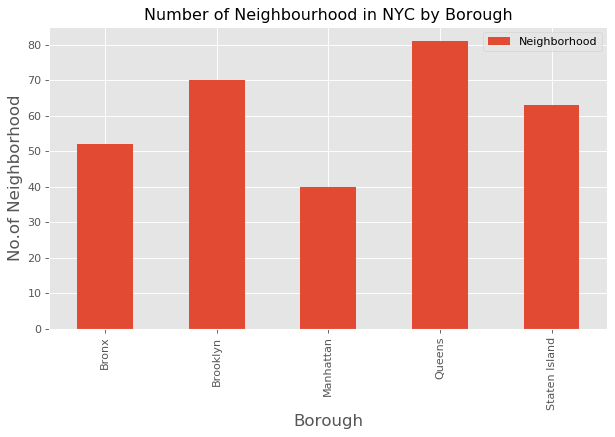

In [63]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

#### Based on the data, Queens is the most densely populated borough in New York City with 80 neighborhoods

In [68]:
# prepare neighborhood list that contains korean restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_resturants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(new_york_data),')','Korean Resturants in '+Neighborhood+', '+Borough+':'+str(len(korean_resturants)))
    for resturant_detail in korean_resturants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Resturants in Wakefield, Bronx:0
( 2 / 306 ) Korean Resturants in Co-op City, Bronx:0
( 3 / 306 ) Korean Resturants in Eastchester, Bronx:0
( 4 / 306 ) Korean Resturants in Fieldston, Bronx:0
( 5 / 306 ) Korean Resturants in Riverdale, Bronx:0
( 6 / 306 ) Korean Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Korean Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Korean Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Korean Resturants in Norwood, Bronx:0
( 10 / 306 ) Korean Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Korean Resturants in Baychester, Bronx:0
( 12 / 306 ) Korean Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Korean Resturants in City Island, Bronx:0
( 14 / 306 ) Korean Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Korean Resturants in University Heights, Bronx:0
( 16 / 306 ) Korean Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Korean Resturants in Fordham, Bronx:0
( 18 / 306 ) Korean Resturants in East Tremont, Bronx:0
( 19 / 306 ) Kor

KeyError: 'groups'

In [69]:
korean_rest_ny.head()

Borough      Neighborhood                        ID  \
0  Brooklyn       Bensonhurst  57049cb4498efcebf6578c1b   
1  Brooklyn    Brighton Beach  4c9d5c0303133704a96f5ed5   
2  Brooklyn  Prospect Heights  4fa162e0e4b0badc81404a51   
3  Brooklyn      Williamsburg  52bf3053498e754b09a440b5   
4  Brooklyn          Bushwick  5cf40f14d552c7002c6cc481   

                         Name  
0                   Cafe Lily  
1  Cafe At Your Mother-in-Law  
2                Kimchi Grill  
3                      Dotory  
4                      Kichin

In [70]:
korean_rest_ny.shape

(85, 4)

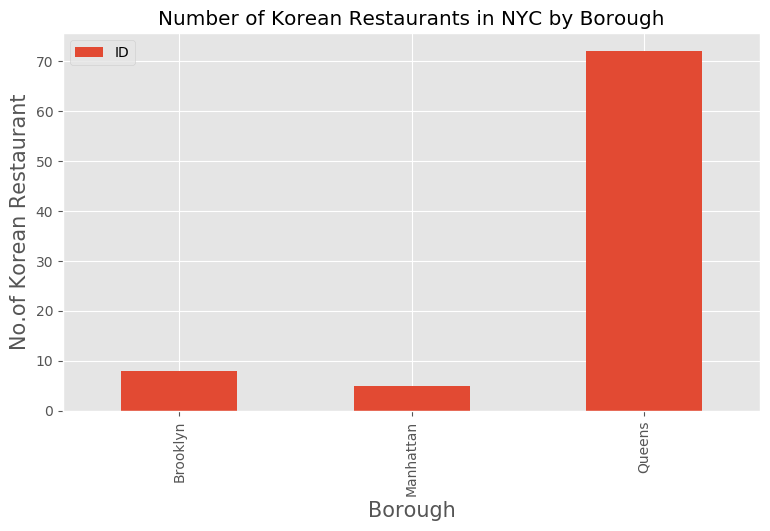

In [71]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Korean Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Korean Restaurant', fontsize=15)
#giving a bar plot
korean_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


#### It is noted that Queens has the highest number of Korean Restaurants

In [72]:
korean_rest_ny[korean_rest_ny['Borough']=='Queens']

Borough     Neighborhood                        ID  \
13  Queens          Astoria  5c0db9ecbfc6d0002c85e28e   
14  Queens  Jackson Heights  4b1dcb05f964a5205d1524e3   
15  Queens         Elmhurst  4b1dcb05f964a5205d1524e3   
16  Queens         Flushing  4ae39cb6f964a520439721e3   
17  Queens         Flushing  4b80790bf964a5209b7530e3   
18  Queens         Flushing  4c86de6de602b1f78c9fc37a   
19  Queens         Flushing  4bd6436dcfa7b713606927da   
20  Queens         Flushing  57c0c497cd10e5cf8037c207   
21  Queens        Sunnyside  57ab54da498e7d61e0c1fe0e   
22  Queens        Ridgewood  58d070dbe309e12fbd02d163   
23  Queens    College Point  4d3c9f7ea2e4b1f707f4ea25   
24  Queens          Bayside  4c8425a0d34ca1436d443c80   
25  Queens          Bayside  4c7193e2f3279c74b4f2a62d   
26  Queens          Bayside  5aede1c167e5f2002c22a953   
27  Queens       Auburndale  4eefef69be7ba3ed7b202455   
28  Queens       Auburndale  4bd3578041b9ef3b05f0ffe5   
29  Queens       Auburndale  4e9a22285503cfce742062a1   
30  Queens       Auburndale  4dd9a5cfc65bee535ae8e26f   
31  Queens       Auburndale  4b565b29f964a520eb0c28e3   
32  Queens       Auburndale  4c49dd1ffbafc9282eb27fdb   
33  Queens       Auburndale  4cdf457c78ddf04ddd07a098   
34  Queens       Auburndale  4bd2147ba8b3a593fc15675f   
35  Queens       Auburndale  4e8b2f17775b3662040325e8   
36  Queens       Auburndale  4c1eb73bb4e62d7fcebade93   
37  Queens       Auburndale  4bec93d8fd60a5939f403bf1   
38  Queens       Auburndale  4bf814b25317a5934f1fff7e   
39  Queens       Auburndale  4b79ffc4f964a520651e2fe3   
40  Queens       Auburndale  4fdcb70fe4b01549c03ede56   
41  Queens      Little Neck  5b3badba3731ee002cc9e31a   
42  Queens       Douglaston  5b3badba3731ee002cc9e31a   
43  Queens  Oakland Gardens  4c8adb923dc2a1cda816b132   
44  Queens  Oakland Gardens  58efc04912c8f0495ec6865c   
45  Queens  Oakland Gardens  526c1acf11d288dc8354b7b9   
46  Queens      Murray Hill  4b830e44f964a520ebf430e3   
47  Queens      Murray Hill  4b8f0931f964a520d04533e3   
48  Queens      Murray Hill  49e10e0bf964a52089611fe3   
49  Queens      Murray Hill  4baeabe6f964a52037cd3be3   
50  Queens      Murray Hill  4c7ad3dda86837048bee144d   
51  Queens      Murray Hill  56db53cc498eed9b68621019   
52  Queens      Murray Hill  5590598a498eb1c3f975b6a6   
53  Queens      Murray Hill  4ca67385b7106dcb6e3b5ea5   
54  Queens      Murray Hill  4ad3bfabf964a52016e620e3   
55  Queens      Murray Hill  569ada51498eb50a95dab87f   
56  Queens      Murray Hill  5518a1a8498e4c7fe6268b88   
57  Queens      Murray Hill  51c612d9498e52a02241e27b   
58  Queens      Murray Hill  548cd91c498e98c507b00851   
59  Queens      Murray Hill  4eefef69be7ba3ed7b202455   
60  Queens      Murray Hill  5cbb9019237dee002cb9f069   
61  Queens      Murray Hill  57c0c497cd10e5cf8037c207   
62  Queens      Murray Hill  4bd3578041b9ef3b05f0ffe5   
63  Queens      Murray Hill  58756dc845c3ed5546c88309   
64  Queens      Murray Hill  5078a6d6e4b065f1dcd66110   
65  Queens      Murray Hill  5147a0bce4b09c3bed35c23b   
66  Queens      Murray Hill  4c06f2c00e0a2d7f85abec0c   
67  Queens      Murray Hill  4e665433b0fb188e8f56fb2b   
68  Queens      Murray Hill  548b8548498e88452c81006e   
69  Queens      Murray Hill  5521d4be498ed5c1ea40e4de   
70  Queens      Murray Hill  4a469916f964a5202ba91fe3   
71  Queens      Murray Hill  4cdf457c78ddf04ddd07a098   
72  Queens      Murray Hill  4e41cfa1b61ca5ba3b1f6db5   
73  Queens      Murray Hill  4eb5c949cc2143e828277958   
74  Queens      Murray Hill  4e8b2f17775b3662040325e8   
75  Queens      Murray Hill  4ec2cccf8231a83de8cf15ed   
76  Queens      Murray Hill  4d85677302eb5481ee0744f5   
77  Queens      Murray Hill  4bf814b25317a5934f1fff7e   
78  Queens      Murray Hill  4b89c358f964a5207c4d32e3   
79  Queens      Murray Hill  4c119b91d41e76b0d3cc310d   
80  Queens      Murray Hill  4b79ffc4f964a520651e2fe3   
81  Queens      Murray Hill  4fd288ece4b0191b9b83648f   
82  Queens   

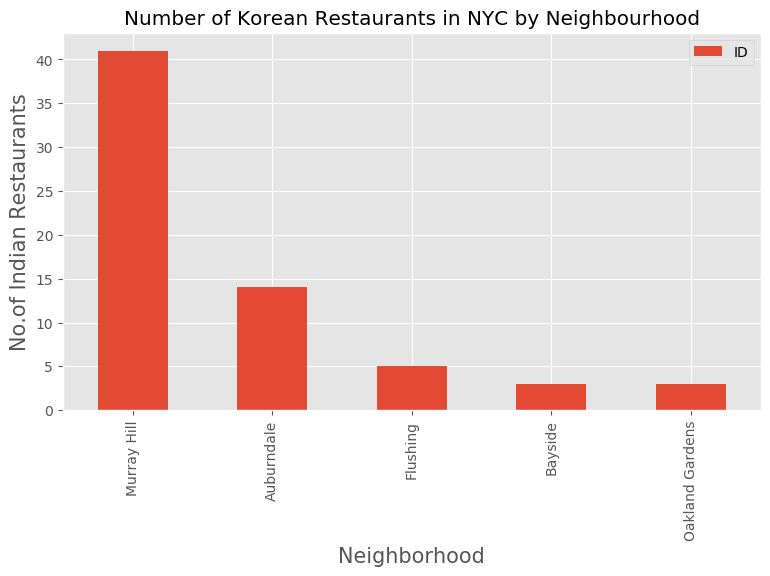

In [73]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Korean Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Restaurants', fontsize=15)
#giving a bar plot
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### Murray Hill in Queens has the most Indian Resturants with a total count of 40.

In [74]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains korean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  57049cb4498efcebf6578c1b  Cafe Lily      8     6.5     7
( 1 / 85 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4c9d5c0303133704a96f5ed5  Cafe At Your Mother-in-Law     30     7.4    28
( 2 / 85 ) processed
                         ID          Name  Likes  Rating  Tips
0  4fa162e0e4b0badc81404a51  Kimchi Grill    289     8.4   108
( 3 / 85 ) processed
                         ID    Name  Likes  Rating  Tips
0  52bf3053498e754b09a440b5  Dotory    139     8.4    44
( 4 / 85 ) processed
                         ID    Name  Likes  Rating  Tips
0  5cf40f14d552c7002c6cc481  Kichin     27     9.0     4
( 5 / 85 ) processed
                         ID     Name  Likes  Rating  Tips
0  5bba42ff7dc9e1002cd1a1df  Haenyeo     79     8.6    13
( 6 / 85 ) processed
                         ID        Name  Likes  Rating  Tips
0  5ae4e10ffe3740002d8a897e  Slow Loris     16     8.4     5
( 7 / 85

In [75]:
korean_rest_stats_ny.head()

Borough      Neighborhood                        ID  \
0  Brooklyn       Bensonhurst  57049cb4498efcebf6578c1b   
1  Brooklyn    Brighton Beach  4c9d5c0303133704a96f5ed5   
2  Brooklyn  Prospect Heights  4fa162e0e4b0badc81404a51   
3  Brooklyn      Williamsburg  52bf3053498e754b09a440b5   
4  Brooklyn          Bushwick  5cf40f14d552c7002c6cc481   

                         Name Likes  Rating Tips  
0                   Cafe Lily     8     6.5    7  
1  Cafe At Your Mother-in-Law    30     7.4   28  
2                Kimchi Grill   289     8.4  108  
3                      Dotory   139     8.4   44  
4                      Kichin    27     9.0    4

In [76]:
korean_rest_stats_ny.shape

(85, 7)

In [77]:
korean_rest_ny.shape

(85, 4)

In [78]:
korean_rest_stats_ny.to_csv('korean_rest_stats_ny.csv', index=False)

In [79]:
korean_rest_stats_ny_csv=pd.read_csv('korean_rest_stats_ny.csv')

In [80]:
korean_rest_stats_ny_csv.shape

(85, 7)

In [81]:
korean_rest_stats_ny_csv.head()

Borough      Neighborhood                        ID  \
0  Brooklyn       Bensonhurst  57049cb4498efcebf6578c1b   
1  Brooklyn    Brighton Beach  4c9d5c0303133704a96f5ed5   
2  Brooklyn  Prospect Heights  4fa162e0e4b0badc81404a51   
3  Brooklyn      Williamsburg  52bf3053498e754b09a440b5   
4  Brooklyn          Bushwick  5cf40f14d552c7002c6cc481   

                         Name  Likes  Rating  Tips  
0                   Cafe Lily      8     6.5     7  
1  Cafe At Your Mother-in-Law     30     7.4    28  
2                Kimchi Grill    289     8.4   108  
3                      Dotory    139     8.4    44  
4                      Kichin     27     9.0     4

In [82]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
Borough         85 non-null object
Neighborhood    85 non-null object
ID              85 non-null object
Name            85 non-null object
Likes           85 non-null object
Rating          85 non-null float64
Tips            85 non-null object
dtypes: float64(1), object(6)
memory usage: 4.7+ KB


In [83]:
korean_rest_stats_ny['Likes']=korean_rest_stats_ny['Likes'].astype('float64')

In [84]:
korean_rest_stats_ny['Tips']=korean_rest_stats_ny['Tips'].astype('float64')

In [85]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 7 columns):
Borough         85 non-null object
Neighborhood    85 non-null object
ID              85 non-null object
Name            85 non-null object
Likes           85 non-null float64
Rating          85 non-null float64
Tips            85 non-null float64
dtypes: float64(3), object(4)
memory usage: 4.7+ KB


In [86]:
# Restaurants with maximum Likes
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                 Murray Hill
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1228
Rating                               8.7
Tips                                 205
Name: 10, dtype: object

In [87]:
# Restaurants with maximum Rating
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5cf40f14d552c7002c6cc481
Name                              Kichin
Likes                                 27
Rating                                 9
Tips                                   4
Name: 4, dtype: object

In [88]:
# Restaurants with maximum Tips
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                 Murray Hill
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1228
Rating                               8.7
Tips                                 205
Name: 10, dtype: object

In [89]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [90]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
5                    Bushwick            9.00
16                 Park Slope            8.60
23               Williamsburg            8.40
21                 South Side            8.40
18  Prospect Lefferts Gardens            8.40
17           Prospect Heights            8.40
13           Manhattan Valley            8.10
0                     Astoria            8.10
9                    Flushing            7.76
22                  Sunnyside            7.70

In [91]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [92]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
1  Manhattan        8.660000
0   Brooklyn        8.137500
2     Queens        3.530556

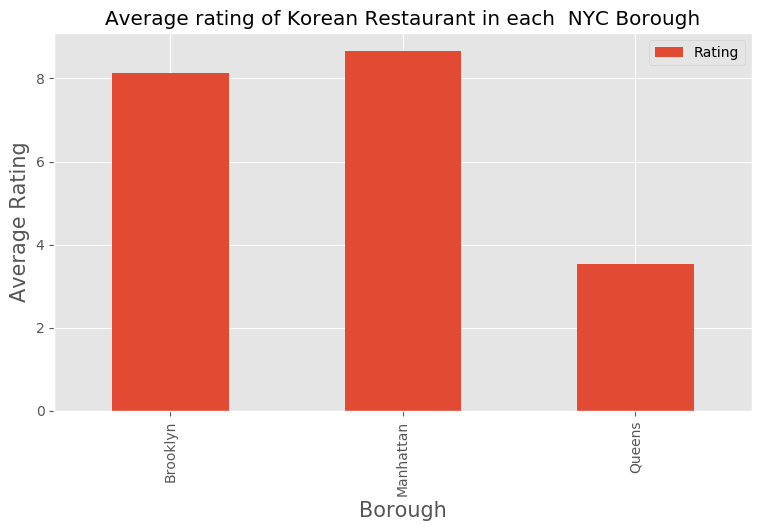

In [103]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Korean Restaurant in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


#### All the neighborhoods with average rating greater or equal 8.0 to be visualized on map¶

In [94]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [95]:
ny_neighborhood_stats

Neighborhood  Average Rating
0                     Astoria             8.1
5                    Bushwick             9.0
13           Manhattan Valley             8.1
16                 Park Slope             8.6
17           Prospect Heights             8.4
18  Prospect Lefferts Gardens             8.4
21                 South Side             8.4
23               Williamsburg             8.4

In [96]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [97]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [98]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Borough               Neighborhood   Latitude  Longitude  Average Rating
1   Brooklyn                   Bushwick  40.698116 -73.925258             9.0
3   Brooklyn                 Park Slope  40.672321 -73.977050             8.6
4   Brooklyn           Prospect Heights  40.676822 -73.964859             8.4
5   Brooklyn  Prospect Lefferts Gardens  40.658420 -73.954899             8.4
6   Brooklyn                 South Side  40.710861 -73.958001             8.4
7   Brooklyn               Williamsburg  40.707144 -73.958115             8.4
0     Queens                    Astoria  40.768509 -73.915654             8.1
2  Manhattan           Manhattan Valley  40.797307 -73.964286             8.1

In [99]:
# create map and display it
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [100]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [101]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

#### Best neighbourhoods in New York that has highest average rating for Korean Restaurants.

In [102]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

## Findings
#### Manhattan/ Astoria, Queens/ Bushwick, Brooklyn are some of the best neighborhoods for Korean cuisine.
#### Manhattan Valley has the lowest rated Korean Resturants in NYC.
#### Manhattan is the best place to stay if you prefer Korean Cuisine.

## Recommendation
#### Midtown or Tribeca in Manhattan would be the best choice to start a restaurant given that

it is the third most populous urban area in New York City (NYC).
it has a population density of 27,826 people per square km, highest of any borough in the United States.
It has the second highest Asian ethnic minority population in NYC.